In [1]:
import gc
import os
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm_notebook
from pathlib import Path
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')

IS_LOCAL = True
if(IS_LOCAL):
    PATH = Path('/mnt/disks/data/santander-customer-transaction/')
else:
    PATH = Path('../input/')
    
os.listdir(str(PATH))

['train.csv.zip',
 'test.csv',
 'sample_submission.csv.zip',
 'test.csv.zip',
 'sample_submission.csv',
 'train.csv']

In [2]:
%%time
train_df = pd.read_csv(str(PATH / 'train.csv'))
test_df = pd.read_csv(str(PATH / 'test.csv'))

CPU times: user 14.9 s, sys: 982 ms, total: 15.8 s
Wall time: 23 s


In [3]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [4]:
target_col = 'target'
predictor_cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]

In [7]:
# in discussion, someone guess the var_68 is date
epoch_datetime = pd.datetime(1900, 1, 1)
trf_var_68_s = (train_df['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)
train_df['date'] = date_s
sorted_train_df = train_df.drop('var_68', axis=1).sort_values('date')

### Conclusion
Train contains:
- ID_code string
- target
- 200 numerical variables, nameed from var_0 to var_199

Test contains:
- ID_code string
- 200 numerical variables, nameed from var_0 to var_199

# Check data

In [33]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (total / data.isnull().count()) * 100
    tt = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['type'] = types
    return np.transpose(tt)

In [34]:
%%time
# check miss value
missing_data(train_df)

CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.56 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
type,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [35]:
missing_data(test_df)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [36]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [37]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_features = sc.fit_transform(train_df[predictor_cols])
sc_train_df = pd.DataFrame(train_features, columns=predictor_cols)

### Conclusion
- min, max, mean, std value for train and test data look quite close
- standard devation is relatively large for both train and test vairable data

In [42]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4, 4, figsize=(14, 14))
    
    for feature in features:
        i += 1
        plt.subplot(4, 4, i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=10)
    plt.show()

<Figure size 432x288 with 0 Axes>

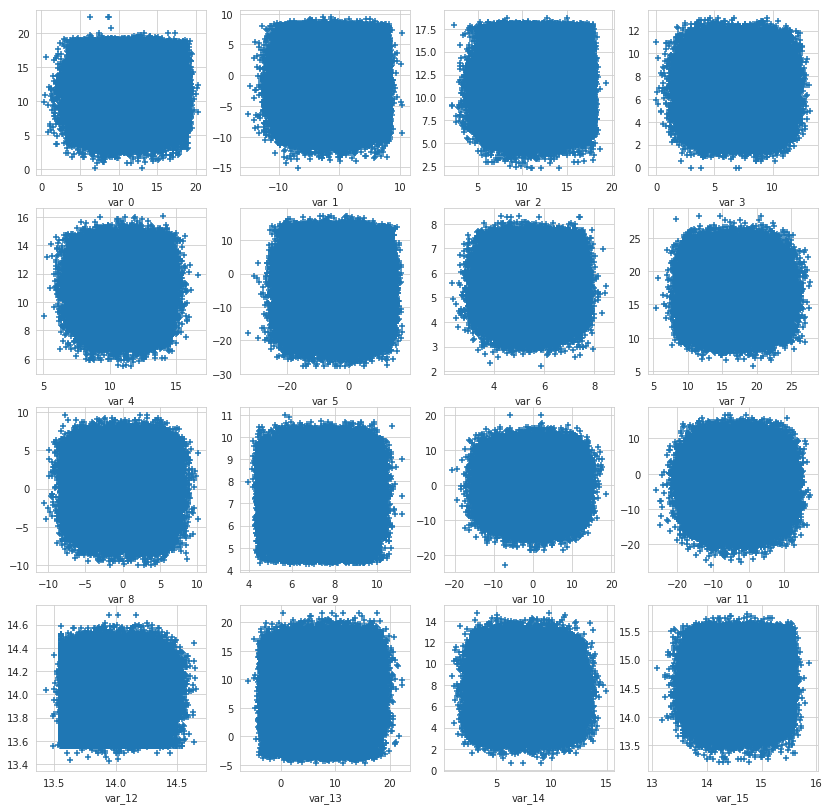

In [43]:
features =  ['var_{}'.format(i) for i in range(0, 16)]
plot_feature_scatter(train_df[features], test_df[features], features)


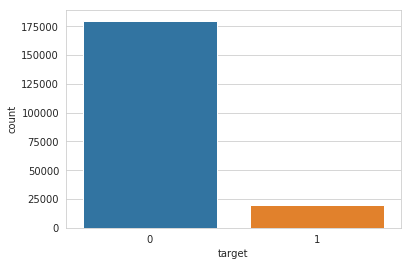

In [44]:
sns.countplot(train_df['target'])

In [54]:
print('This is unbalanced data and the target value with 1 is {}%'.format(
    train_df['target'].value_counts()[1] / train_df.shape[0] * 100))
                                                                         

This is unbalanced data and the target value with 1 is 10.049%


In [6]:
# Correlation
train_df[predictor_cols[0:2]].corr()



,var_0,var_1
var_0,1.000000,-0.000544
var_1,-0.000544,1.000000


# Density plot of features

In [5]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('darkgrid')
    plt.figure()
    fig, ax = plt.subplots(10, 5, figsize=(18, 22))
    for feature in features:
        i += 1
        plt.subplot(10, 5, i)
        sns.kdeplot(df1[feature], label=label1)
        sns.kdeplot(df2[feature], label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show()
    

In [6]:
def plot_feature(df1, df2, label1, label2, feature):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    sns.kdeplot(df1[feature], ax=ax, label=label1, color='r', bw=bw)
    sns.kdeplot(df2[feature], ax=ax, label=label2, color='g', bw=bw)
    plt.show()

In [7]:
target_0_df = train_df.loc[train_df['target'] == 0]
target_1_df = train_df.loc[train_df['target'] == 1]

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_df[predictor_cols], train_df[target_col])
#res = cross_val_score(clf, train_df[predictor_cols], train_df[target_col], cv=3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [22]:
 = clf.apply(train_df[predictor_cols])


array([18015, 15206, 20094, ...,  8148,  4858,  8525])

In [24]:
clf.decision_path(train_df[predictor_cols])

<200000x23599 sparse matrix of type '<class 'numpy.int64'>'
	with 11353321 stored elements in Compressed Sparse Row format>

"\nplt.subplot(2, 2, 2)\nplt.plot(peak_index_2, target_1_df[feature].values[peak_index_2], 'ob')\nplt.plot(target_1_df[feature].values)\nplt.legend(['distance'])\n\nplt.subplot(2, 2, 3)\nplt.plot(peak_index_3, target_1_df[feature].values[peak_index_3], 'vg')\nplt.plot(target_1_df[feature].values)\nplt.legend(['distance'])\n\nplt.subplot(2, 2, 4)\nplt.plot(peak_index_4, target_1_df[feature].values[peak_index_4], 'xk')\nplt.plot(target_1_df[feature].values)\nplt.legend(['distance'])\n"

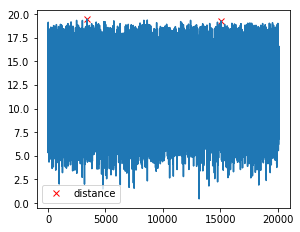

In [138]:
from scipy import signal
feature = 'var_0'
peak_index_1, _ = signal.find_peaks(target_1_df[feature].values, distance=10000)
#peak_index_2, _ = signal.find_peaks(target_1_df[feature].values, prominence=1) 
#peak_index_3, _ = signal.find_peaks(target_1_df[feature].values, width=20)
#peak_index_4, _ = signal.find_peaks(target_1_df[feature].values, threshold=0.4) 

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(peak_index_1, target_1_df[feature].values[peak_index_1], 'xr')
plt.plot(target_1_df[feature].values)
plt.legend(['distance'])
'''
plt.subplot(2, 2, 2)
plt.plot(peak_index_2, target_1_df[feature].values[peak_index_2], 'ob')
plt.plot(target_1_df[feature].values)
plt.legend(['distance'])

plt.subplot(2, 2, 3)
plt.plot(peak_index_3, target_1_df[feature].values[peak_index_3], 'vg')
plt.plot(target_1_df[feature].values)
plt.legend(['distance'])

plt.subplot(2, 2, 4)
plt.plot(peak_index_4, target_1_df[feature].values[peak_index_4], 'xk')
plt.plot(target_1_df[feature].values)
plt.legend(['distance'])
'''

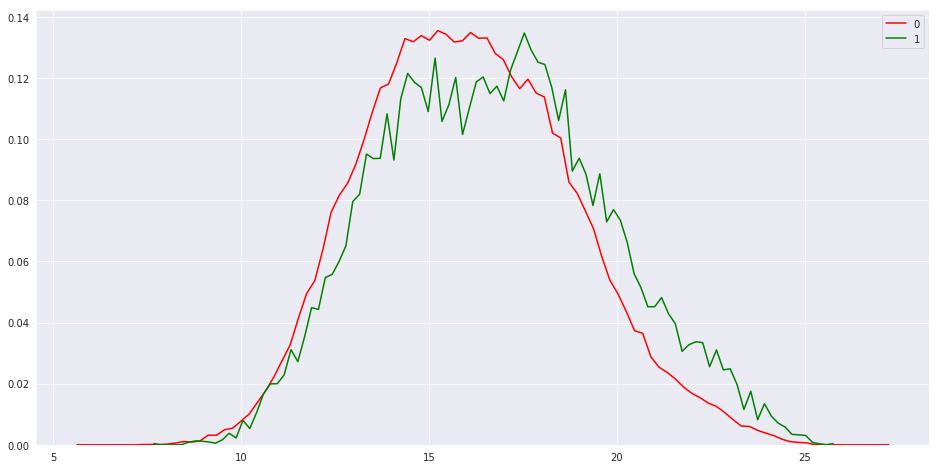

In [38]:
feature = 'var_2'
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
bw = 0.01
sns.kdeplot(target_0_df[feature].values + target_0_df['var_6'].values, ax=ax, label='0', color='r', bw=bw)
a = sns.kdeplot(target_1_df[feature].values + target_1_df['var_6'].values, ax=ax, label='1', color='g', bw=bw)
#sns.kdeplot(train_df[feature].values, ax=ax, label='train', color='b', bw=bw)
#plt.axvline(11.047, linewidth=1, color='r')
#plt.axvline(15.224519999999998, linewidth=1, color='r')
plt.show()

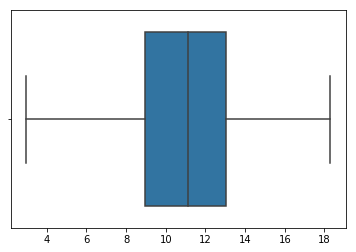

In [170]:
sns.boxplot(target_1_df[feature].values)

In [188]:
cate_range = target_1_df[feature].quantile([0.25, 0.5, 0.75, 1]).values.tolist()
cate_range.insert(0, target_1_df[feature].min())

In [190]:
res = pd.cut(target_1_df[feature], cate_range, include_lowest=True,
             labels=list(map(lambda i:str(i), range(1, len(cate_range)))))

In [12]:
train_df[train_df[feature] < 13.6][target_col].value_counts()

0    3158
1     927
Name: target, dtype: int64

In [52]:
def plot_divide_feature_distribution(df1, df2, label1, label2, target_feature,
                                     features, smooth_factor=1e-10):
    sns.set_style('darkgrid')
    plt.figure()
    fig, ax = plt.subplots(10, 5, figsize=(18, 22))
    i = 0
    for f in features:
        i += 1
        plt.subplot(10, 5, i)
        sns.kdeplot(df1[target_feature] / (df1[f] + smooth_factor), label=label1)
        sns.kdeplot(df2[target_feature] / (df2[f] + smooth_factor), label=label2)
        plt.xlabel(f, fontsize=10)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show()    

In [ ]:
plot_divide_feature_distribution(target_0_df, target_1_df, '0', '1', 'var_0',
                                 predictor_cols[1:13])


In [98]:
def feature_auc_test(X, y):
    clf = LogisticRegression(random_state=2319, solver='lbfgs', multi_class='ovr', max_iter=10000)
    clf.fit(X, y) 
    print(roc_auc_score(y, clf.predict_proba(X)[:, 1]))
    

In [102]:
#X = (train_df['var_0'] / (train_df['var_199'] + smooth_factor)).values.reshape(-1, 1)

X = np.exp(train_df['var_0']).values.reshape(-1, 1)
feature_auc_test(X, y)

0.4551480459393069


In [67]:
auc_df[auc_df.feature == 'var_0']

,feature,auc
0,var_0,0.544852


In [45]:
y = train_df[target_col].values
auc_df = pd.DataFrame(columns=['feature', 'auc'], dtype=(str, float))
for i, f in enumerate(predictor_cols):
    X = train_df[f].values.reshape(-1, 1)
    clf = LogisticRegression(random_state=2319, solver='lbfgs', multi_class='ovr', max_iter=10000)
    clf.fit(X, y)
    y_pred = clf.predict_proba(X)[:, 1]
    auc_df.loc[i, 'feature'] = f
    auc_df.loc[i, 'auc'] = roc_auc_score(y, y_pred)
    
auc_df = auc_df.sort_values('auc', ascending=False)  
auc_df.head()
    

In [60]:
auc_df.auc.quantile([0.25, 0.5, 0.75, 1])

0.25    0.511496
0.50    0.524037
0.75    0.535942
1.00    0.567239
Name: auc, dtype: object

In [65]:
auc_df[auc_df.auc > 0.54]['feature'].values

array(['var_81', 'var_139', 'var_6', 'var_12', 'var_110', 'var_146',
       'var_76', 'var_53', 'var_21', 'var_174', 'var_26', 'var_22',
       'var_99', 'var_166', 'var_165', 'var_190', 'var_148', 'var_80',
       'var_13', 'var_2', 'var_133', 'var_34', 'var_115', 'var_198',
       'var_149', 'var_169', 'var_0', 'var_1', 'var_40', 'var_109',
       'var_184', 'var_192', 'var_78', 'var_92', 'var_67', 'var_179',
       'var_170', 'var_154', 'var_191', 'var_94'], dtype=object)

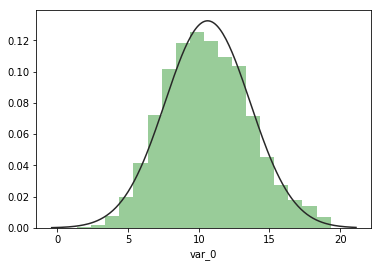

In [29]:
from scipy.stats import norm
sns.distplot(target_0_df['var_0'], color='g', kde=False, hist=True, bins=20, 
             fit=norm)


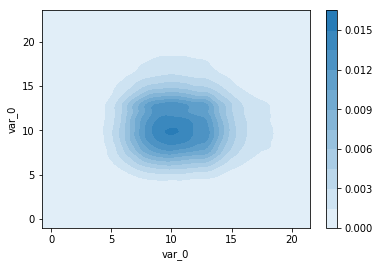

In [21]:
sns.kdeplot(train_df['var_0'], test_df['var_0'], shade=True, cbar=True)


In [48]:
# If the K-S statistic is small or the p-value is high, 
# then we cannot reject the hypothesis that the distributions of the two samples 
# are the same.
from scipy.stats import ks_2samp, entropy
ks_array = np.zeros((len(predictor_cols), 2))
for i, c in enumerate(predictor_cols):
    ks = ks_2samp(target_0_df[c], target_1_df[c])
    ks_array[i, 0] = ks.statistic
    ks_array[i, 1] = ks.pvalue
    
ks_df = pd.DataFrame(ks_array, columns=['statistic', 'p-value'])
ks_df['feature'] = predictor_cols

In [66]:
ks_stats = ks_df[ks_df['p-value'] < 0.01].feature.values

In [59]:
# use t-test to check the features of target 0 and target 1 has same mean
from scipy import stats
t_array = np.zeros((len(predictor_cols), 2))
f_array = np.zeros((len(predictor_cols), 2))

for i, c in enumerate(predictor_cols):
    t_test = stats.ttest_ind(target_0_df[c], target_1_df[c])
    f_test = stats.f_oneway(target_0_df[c], target_1_df[c])
    f_array[i, 0] = f_test.statistic
    f_array[i, 1] = f_test.pvalue
    t_array[i, 0] = t_test.statistic
    t_array[i, 1] = t_test.pvalue
    
t_df = pd.DataFrame(t_array, columns=['statistic', 'p-value'])
t_df['feature'] = predictor_cols    

f_df = pd.DataFrame(f_array, columns=['statistic', 'p-value'])
f_df['feature'] = predictor_cols    

In [60]:
t_stats = t_df[t_df['p-value'] < 0.01].feature.values
f_stats = f_df[f_df['p-value'] < 0.01].feature.values

In [67]:
set(t_stats).difference(ks_stats)


{'var_129', 'var_14', 'var_153', 'var_37', 'var_61', 'var_73', 'var_79'}

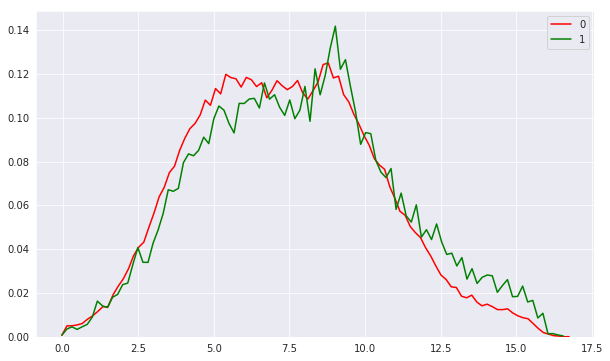

In [106]:
feature = 'var_191'
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bw = 0.01
sns.kdeplot(abs(target_0_df[feature].values), ax=ax, label='0', color='r', bw=bw)
sns.kdeplot(abs(target_1_df[feature].values), ax=ax, label='1', color='g', bw=bw)
#sns.kdeplot(train_df[feature].values, ax=ax, label='train', color='b', bw=bw)
#plt.axvline(11.047, linewidth=1, color='r')
#plt.axvline(15.224519999999998, linewidth=1, color='r')
plt.show()

In [107]:
a = np.sqrt(target_0_df[feature_3].values)
#np.where(np.isnan(a))
a[103], target_0_df[feature_3].values[103]

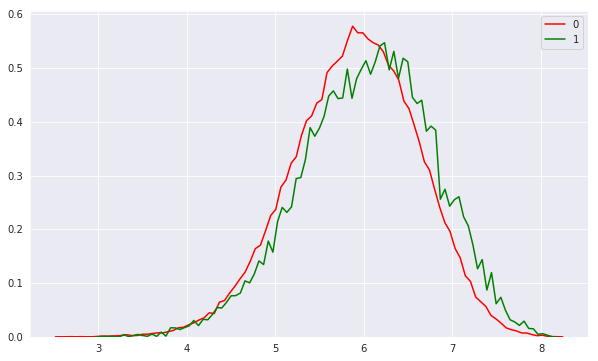

In [116]:
feature_1 = 'var_2'
feature_2 = 'var_6'
feature_3 = 'var_191'
target_0_value = np.sqrt(target_0_df[feature_1].values) +  np.sqrt(abs(target_0_df[feature_3].values))
target_1_value = np.sqrt(target_1_df[feature_1].values) +  np.sqrt(abs(target_1_df[feature_3].values))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bw = 0.01
sns.kdeplot(target_0_value, ax=ax, label='0', color='r', bw=bw)
sns.kdeplot(target_1_value, ax=ax, label='1', color='g', bw=bw)
#sns.kdeplot(train_df[feature].values, ax=ax, label='train', color='b', bw=bw)
#plt.axvline(11.047, linewidth=1, color='r')
#plt.axvline(15.224519999999998, linewidth=1, color='r')
plt.show()

<Figure size 432x288 with 0 Axes>

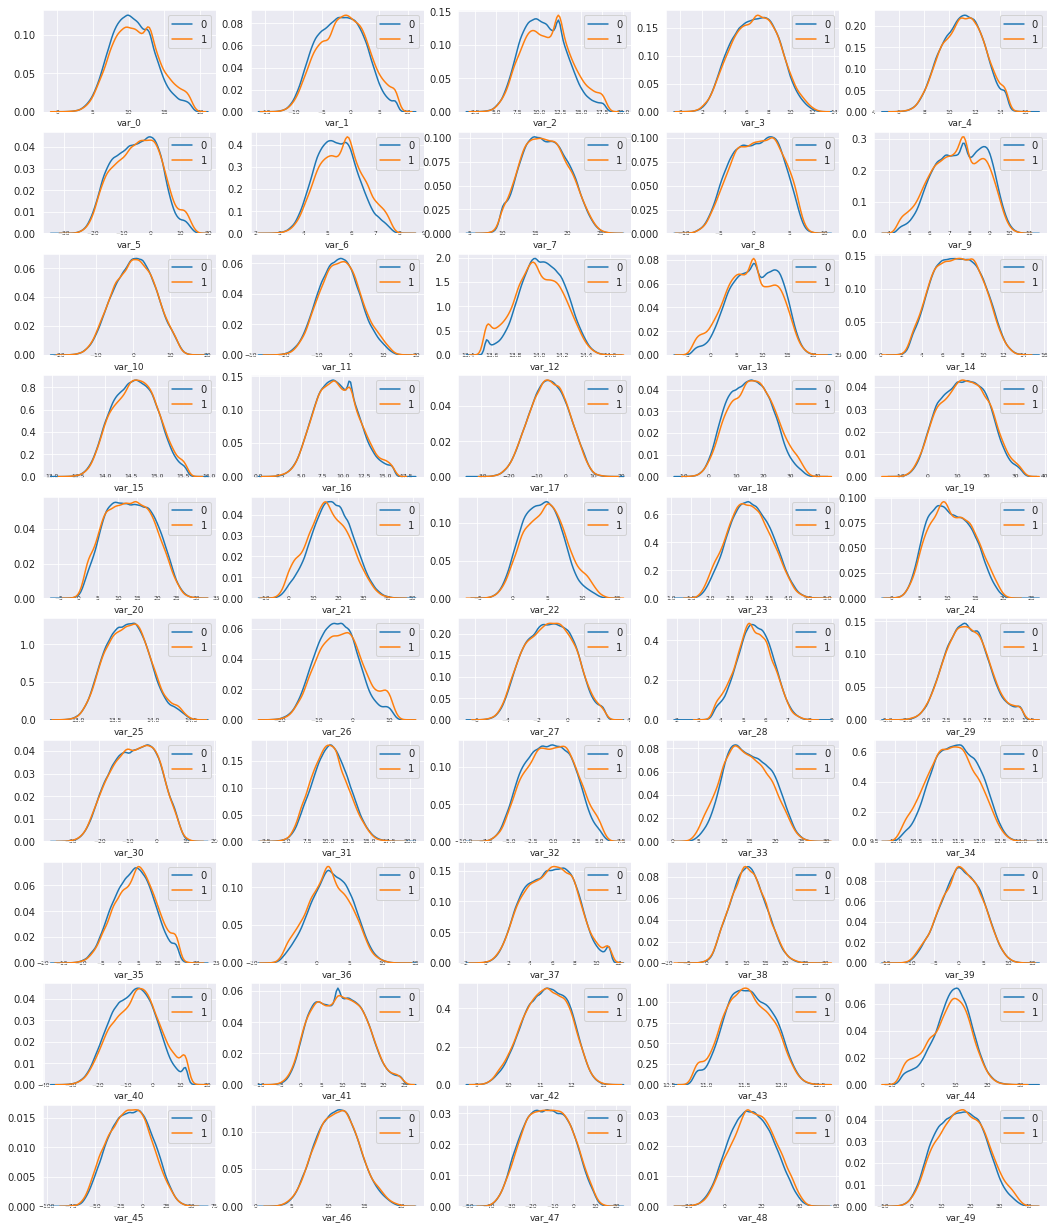

In [32]:
features =  ['var_{}'.format(i) for i in range(0, 50)]
plot_feature_distribution(target_0_df, target_1_df, '0', '1', features)

<Figure size 432x288 with 0 Axes>

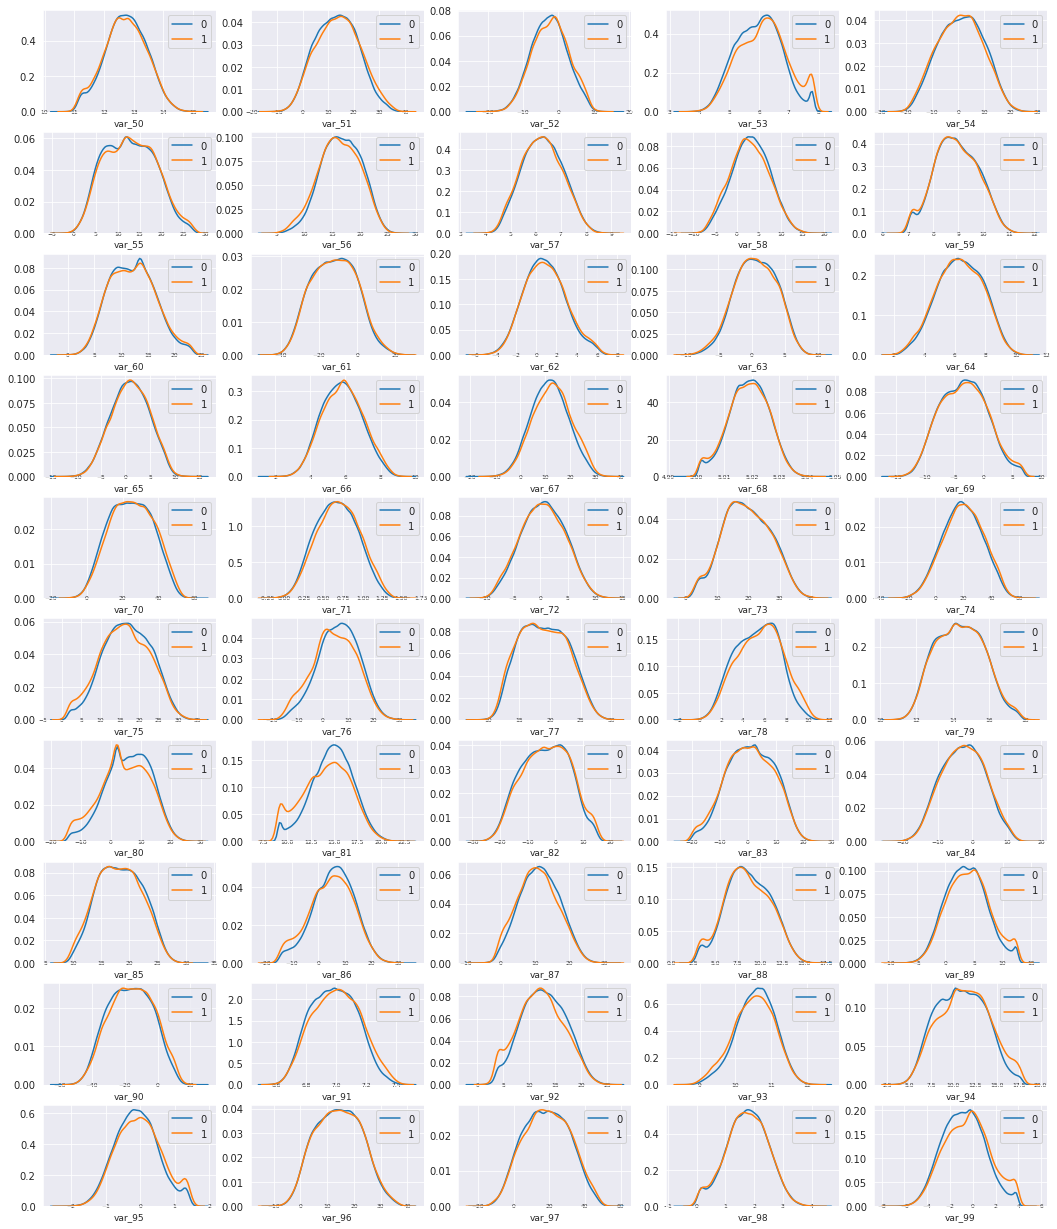

In [33]:
features =  ['var_{}'.format(i) for i in range(50, 100)]
plot_feature_distribution(target_0_df, target_1_df, '0', '1', features)

<Figure size 432x288 with 0 Axes>

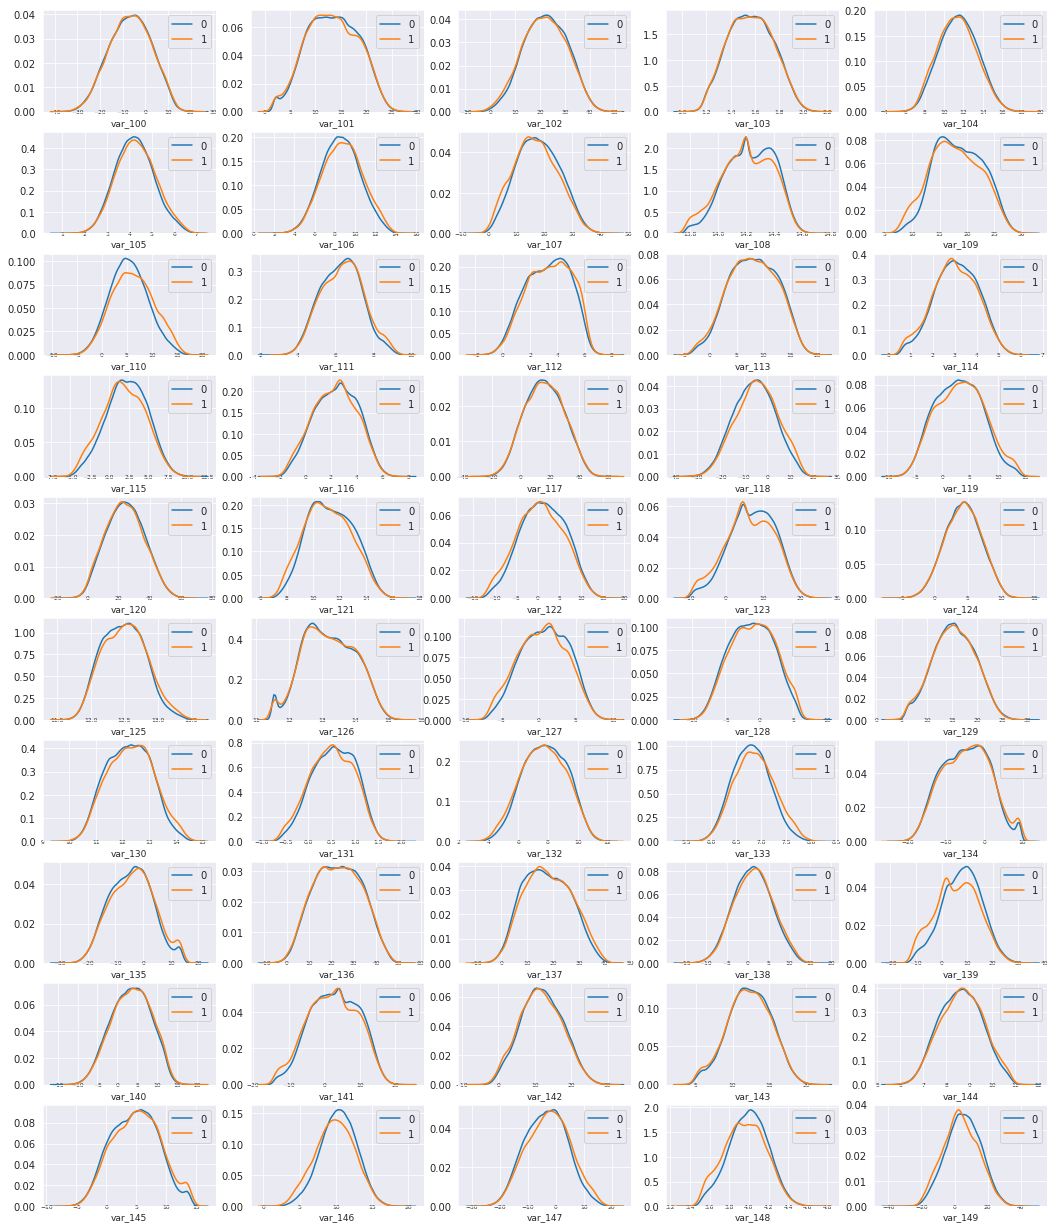

In [34]:
features =  ['var_{}'.format(i) for i in range(100, 150)]
plot_feature_distribution(target_0_df, target_1_df, '0', '1', features)

<Figure size 432x288 with 0 Axes>

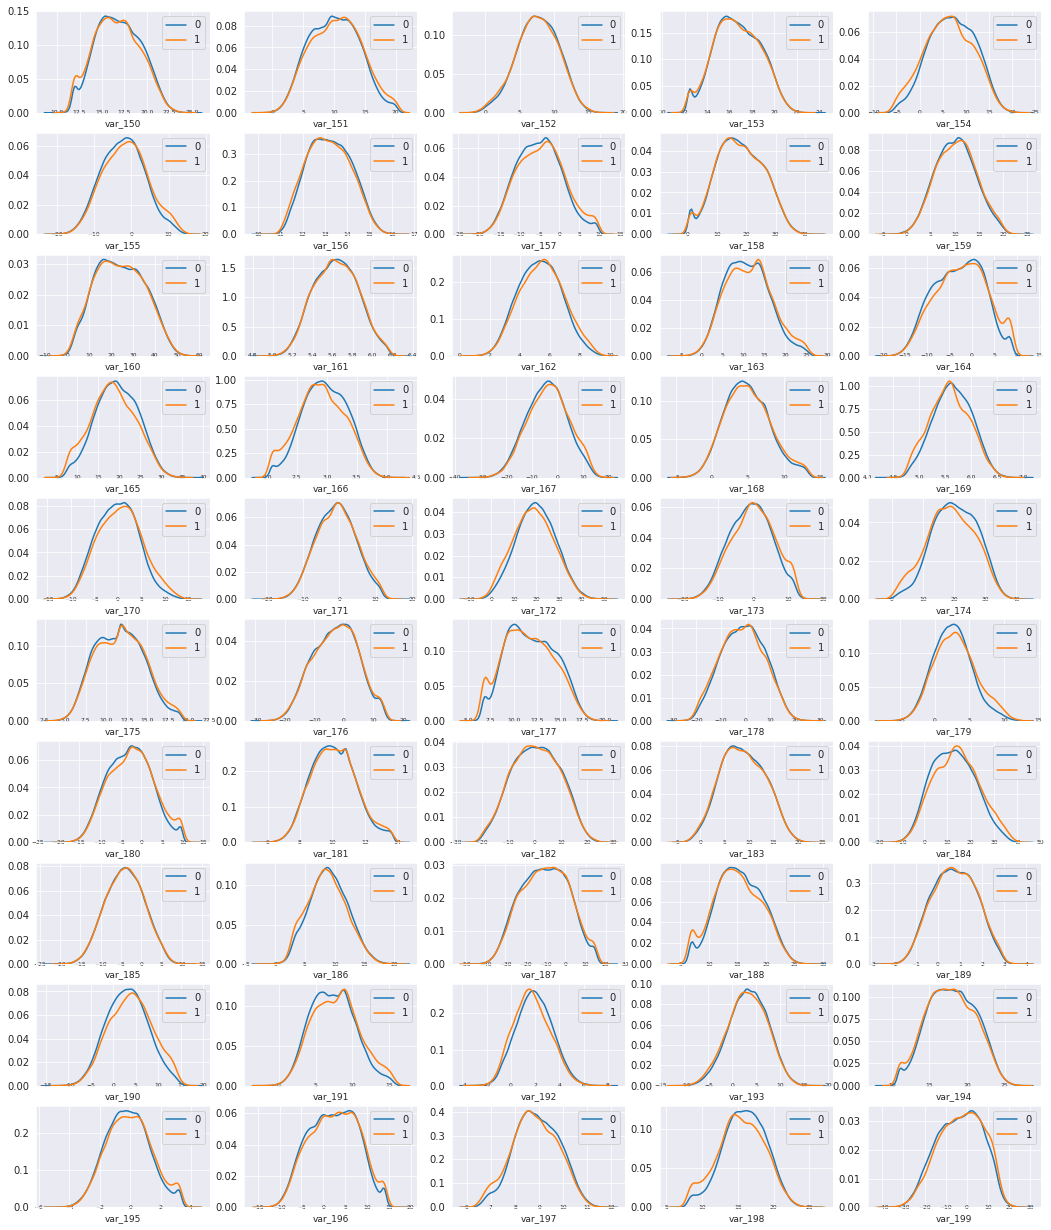

In [35]:
features =  ['var_{}'.format(i) for i in range(150, 200)]
plot_feature_distribution(target_0_df, target_1_df, '0', '1', features)

### Conclusion
We can observe that there is a considerable number of features with significant different distribution for the two targe values.

For example, **var_0**, **var_2**, **var_6**, **var_13**, **var_21**, **var_80**, **var_81** and many others.



<Figure size 432x288 with 0 Axes>

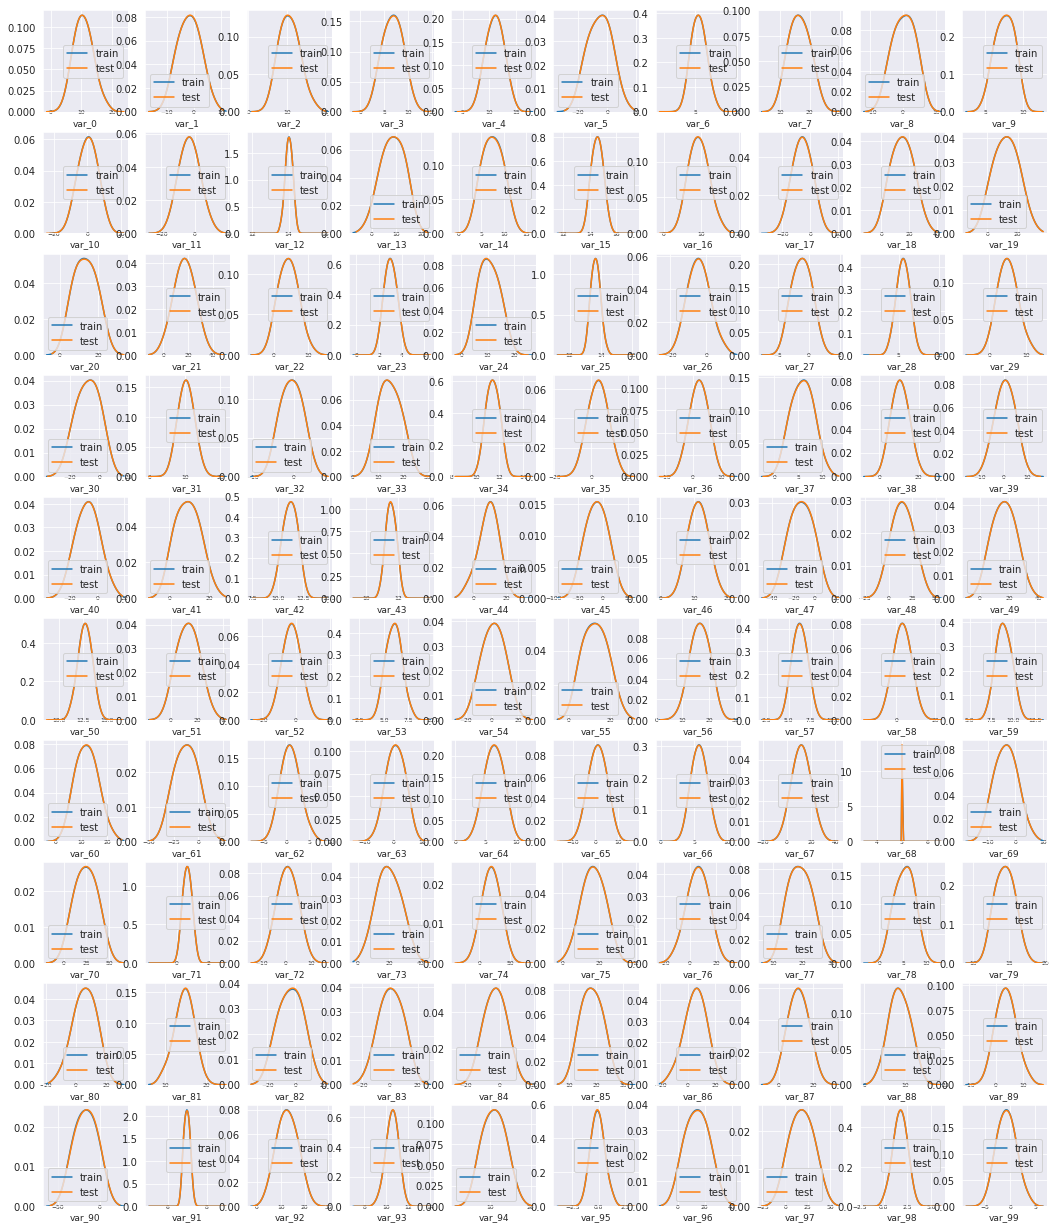

In [71]:
features =  ['var_{}'.format(i) for i in range(0, 100)]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

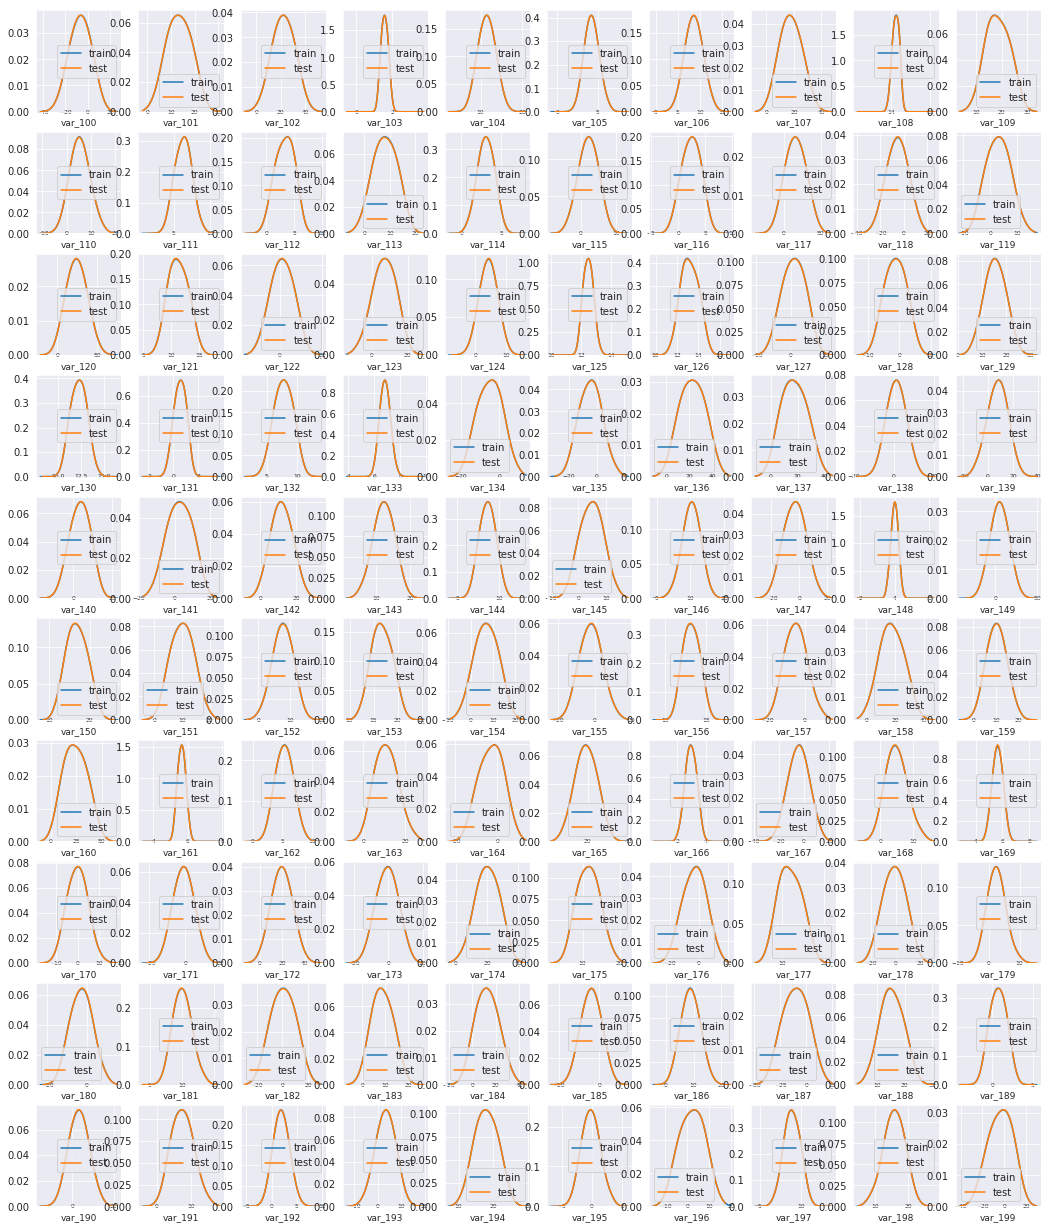

In [72]:
features =  ['var_{}'.format(i) for i in range(100, 200)]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

### Conclusion
The train and test seems to be well ballanced with respect with distribution of the numeric variables.

# Distribution of mean and std
Let's check the distribution of the mean values per row in the train and test set.

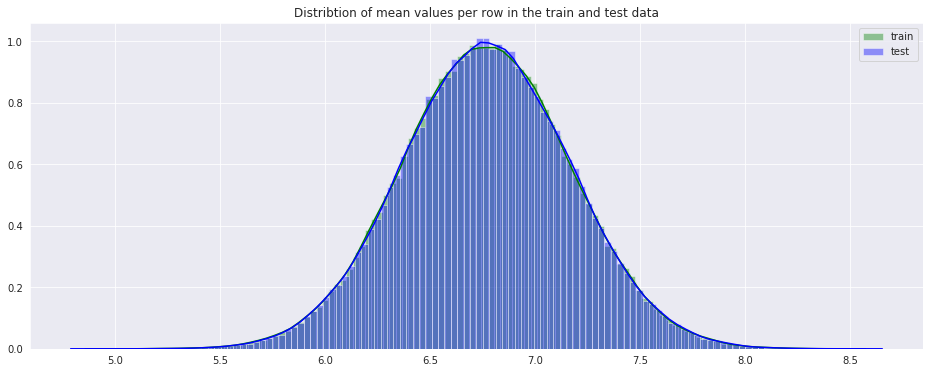

In [91]:
plt.figure(figsize=(16, 6))
features =  ['var_{}'.format(i) for i in range(0, 200)]
plt.title('Distribtion of mean values per row in the train and test data')
sns.distplot(train_df[features].mean(axis=1), color='green', kde=True, bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1), color='blue', kde=True, bins=120, label='test')
plt.legend()
plt.show()


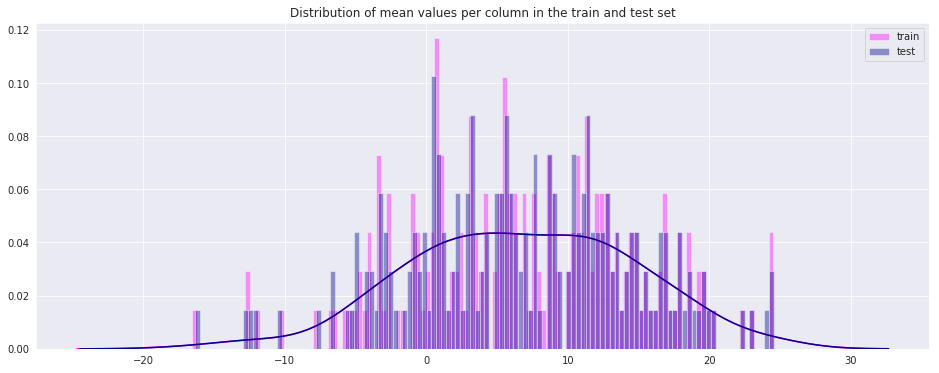

In [79]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0), color="magenta", kde=True, bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0), color="darkblue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

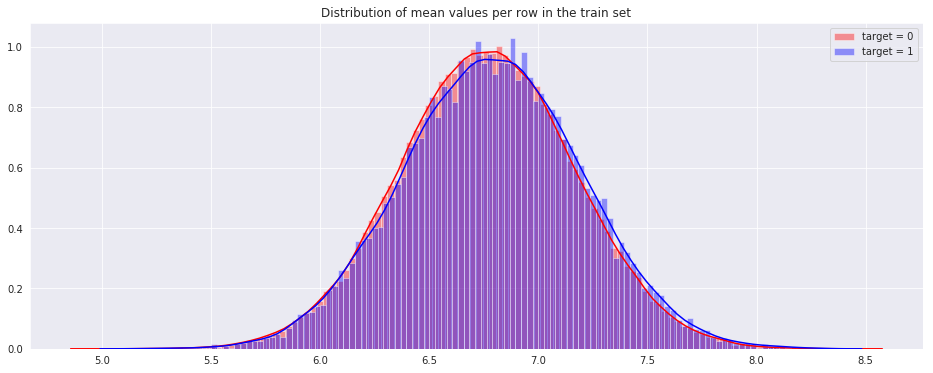

In [92]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1), color="red", kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1), color="blue", kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()


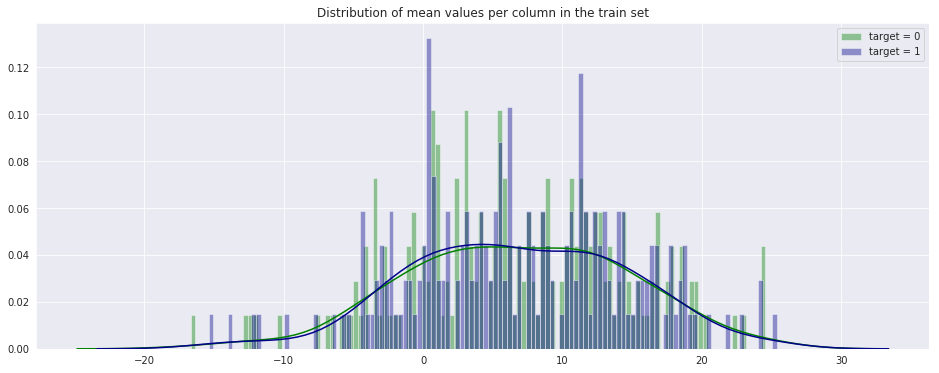

In [94]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0), color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0), color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# Features correlation

In [12]:
correlatins = train_df[predictor_cols].corr().abs()

In [13]:
correlatins

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,0.000544,0.006573,0.003801,0.001326,0.003046,6.982549e-03,0.002429,0.004962,0.002613,...,0.002752,0.000206,0.005373,0.001616,0.001514,0.002073,0.004386,0.000753,0.005776,0.003850
var_1,0.000544,1.000000,0.003980,0.000010,0.000303,0.000902,3.257729e-03,0.001511,0.004098,0.000832,...,0.006627,0.003621,0.002604,0.001153,0.002557,0.000785,0.000377,0.004157,0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,8.825211e-04,0.000991,0.002648,0.001932,...,0.000197,0.001285,0.003400,0.000549,0.002104,0.001070,0.003952,0.001078,0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,0.000322,0.003253,7.743892e-04,0.002500,0.003553,0.000826,...,0.000151,0.002445,0.001530,0.001699,0.001054,0.001206,0.002800,0.001164,0.001651,0.000506
var_4,0.001326,0.000303,0.000723,0.000322,1.000000,0.001368,4.882529e-05,0.004549,0.001194,0.000918,...,0.001514,0.004357,0.003347,0.000813,0.000068,0.003706,0.000513,0.000046,0.001821,0.000786
var_5,0.003046,0.000902,0.001569,0.003253,0.001368,1.000000,2.587780e-03,0.000995,0.000147,0.005279,...,0.001466,0.000022,0.001116,0.002237,0.002543,0.001274,0.002880,0.000535,0.000953,0.002767
var_6,0.006983,0.003258,0.000883,0.000774,0.000049,0.002588,1.000000e+00,0.002548,0.001188,0.005697,...,0.000721,0.005604,0.002563,0.002464,0.001141,0.001244,0.005378,0.003565,0.003025,0.006096
var_7,0.002429,0.001511,0.000991,0.002500,0.004549,0.000995,2.547746e-03,1.000000,0.000814,0.002885,...,0.000337,0.003957,0.001733,0.003219,0.000270,0.001854,0.001045,0.003466,0.000650,0.001457
var_8,0.004962,0.004098,0.002648,0.003553,0.001194,0.000147,1.187995e-03,0.000814,1.000000,0.001073,...,0.002923,0.001151,0.000429,0.001414,0.001313,0.001396,0.003242,0.004583,0.002950,0.000854
var_9,0.002613,0.000832,0.001932,0.000826,0.000918,0.005279,5.696919e-03,0.002885,0.001073,1.000000,...,0.000871,0.002371,0.000014,0.001407,0.003099,0.000868,0.000052,0.003701,0.002343,0.001070


In [14]:
correlatins.unstack().sort_values(kind="quicksort").reset_index()

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


                                           Plots for var_37                                           


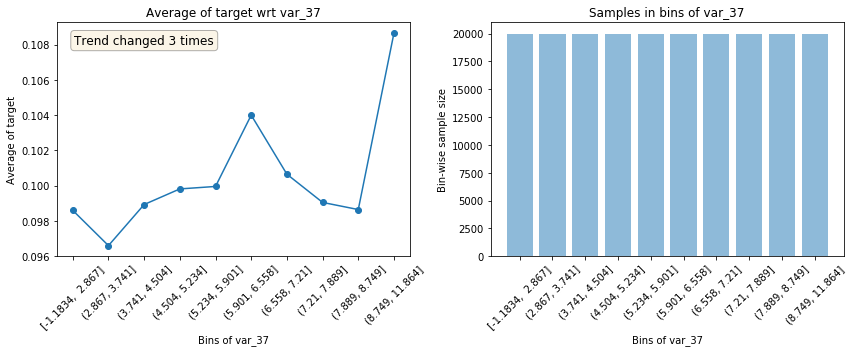

--------------------------------------------------------------------------------------------------------------


                                           Plots for var_38                                           


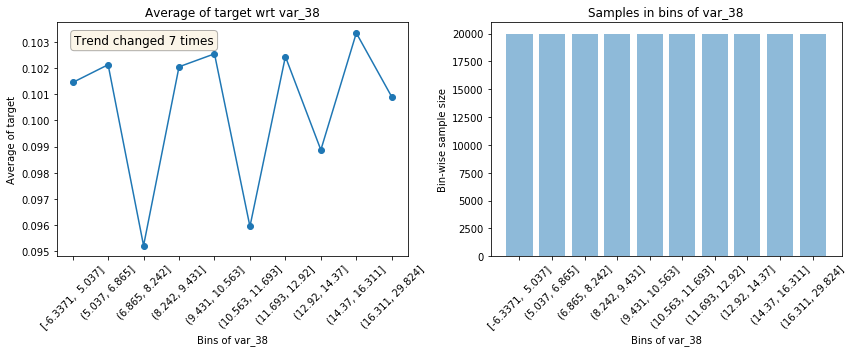

--------------------------------------------------------------------------------------------------------------




In [103]:
from featexp import get_univariate_plots
get_univariate_plots(data=train_df, target_col=target_col, 
                     features_list=predictor_cols[37:39], bins=10)

In [94]:
from featexp import get_trend_stats
stats = get_trend_stats(data=train_df[predictor_cols], target_col=target_col)
stats.sort_values('Trend_changes', ascending=False, inplace=True)

Returning stats for all numeric features


In [95]:
stats

,Feature,Trend_changes
38,var_38,7
103,var_103,7
96,var_96,7
176,var_176,7
63,var_63,6
160,var_160,6
178,var_178,6
47,var_47,6
161,var_161,6
73,var_73,6
